<a href="https://colab.research.google.com/github/alaeddinehamroun/Recommender-Systems/blob/main/user_based_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering
Collaborative filtering is a type of recommendation algorithm that is commonly used in e-commerce and online platforms to recommend items or products to users based on their preferences and behavior. It works by analyzing the behavior and preferences of users and comparing them with those of other users in order to identify patterns and make recommendations.

The basic idea behind collaborative filtering is that users who have similar preferences and behavior in the past are likely to have similar preferences in the future. Therefore, the algorithm uses the ratings or reviews provided by users to identify similar users and then recommends products or items that the similar users have rated highly.

Collaborative filtering has been proven to be effective in many real-world applications, including e-commerce, social networks, and online advertising.


Collaborative filtering has two common approaches: 
* **User-based collaborative filtering:** Focuses on the similarity between users in terms of their preferences and behavior. It works by identifying users who have similar ratings and preferences for items and then recommending items that similar users have rated highly. This approac is based on the assumption that users who have similar preferences and behavior in the past are likely to have similar preferences in the future.


* **Item-based collaborative filtering:** Focuses on the similarity between items in terms of their ratings and popularity. It works by identifying items that are similar to each other based on the ratings they have received from users and then recommending items that are similar to the ones that the user has already liked. This approach is based on the assumption that users who have liked a particular item are likely to like similar items in the future.


Both user-based and item-based collaborative filtering have their own advantages and disadvantages. User-based collaborative filtering tends to work well when the number of users is relatively small and the number of items is large, while item-based collaborative filtering tends to work well when the number of items is small and the number of users is large. Additionally, user-based collaborative filtering can suffer from the cold-start problem, where new users or items have little or no data, while item-based collaborative filtering can suffer from sparsity, where items have few ratings.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.metrics.pairwise import cosine_similarity

import math
from operator import itemgetter
from collections import defaultdict

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2023-04-16 04:36:27--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  6.79MB/s    in 0.8s    

2023-04-16 04:36:28 (6.79 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [3]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [4]:
movies_file = "/content/ml-1m/movies.dat"
ratings_file = "/content/ml-1m/ratings.dat"
movies_cols = ["movie_id", "title", "genres"]
ratings_cols = ["user_id", "movie_id", "rating", "timestamp"]

# Read the files into DataFrames
movies = pd.read_csv(movies_file, sep="::", header=None, names=movies_cols, encoding='ISO-8859-1', engine='python')
ratings = pd.read_csv(ratings_file, sep="::", header=None, names=ratings_cols, encoding='ISO-8859-1', engine='python')

# Data preparation

In [5]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
ratings.drop(['timestamp'], axis=1, inplace=True)

In [10]:
# Rename cols
movies = movies.rename(columns={'movie_id': 'movieId'})
ratings = ratings.rename(columns={'user_id': 'userId', 'movie_id': 'movieId'})

In [11]:
data=pd.merge(movies, ratings, on="movieId")

In [12]:
data.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5


In [13]:
data.drop(['movieId', 'genres'], axis=1, inplace= True)

In [14]:
data.head()

,title,userId,rating
0,Toy Story (1995),1,5
1,Toy Story (1995),6,4
2,Toy Story (1995),8,4
3,Toy Story (1995),9,5
4,Toy Story (1995),10,5


The dataset is too large to fit into memory when creating the similarity matrix, so we reduce the number of rows by selecting only the rows that correspond to the most active users or the most popular movies.

In [15]:
active_users = data["userId"].value_counts().head(1000).index
popular_movies = data["title"].value_counts().head(1000).index
subset_data = data[data["userId"].isin(active_users) & data["title"].isin(popular_movies)]

In [16]:
subset_data.head()

,title,userId,rating
4,Toy Story (1995),10,5
5,Toy Story (1995),18,4
8,Toy Story (1995),23,4
9,Toy Story (1995),26,3
12,Toy Story (1995),36,5


In [17]:
subset_data['userId'].max()

6040

# User-based collaborative filtering

Given a user. Let's call it Bob.

1. We start by creating the user->item rating matrix.

Each row contain the ratings given by a user, and each column contain the ratings received by an item(a movie).

A matrix of five users and five items(movies) could look like this:

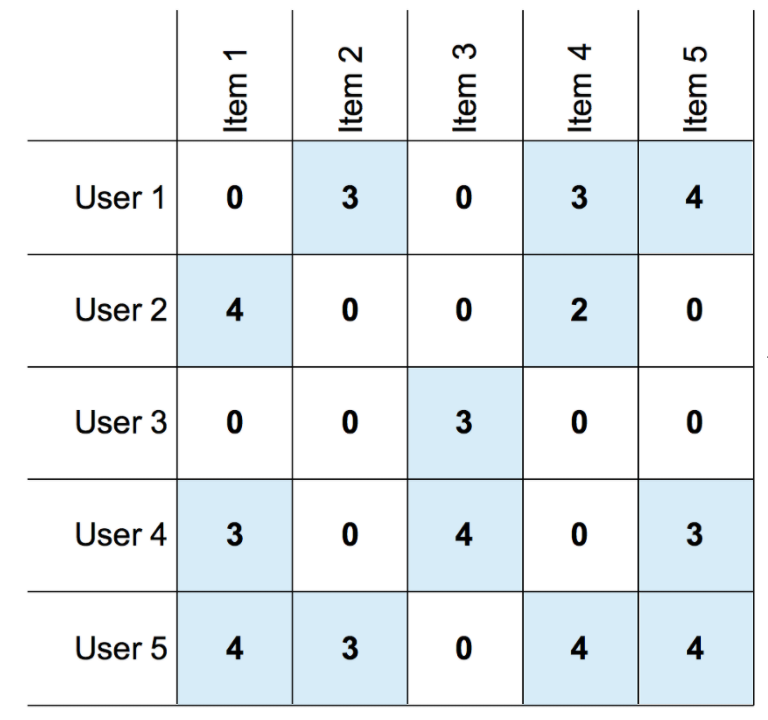
2. Then we compute the user->user similarity matrix

    Each row/column contain how similar a user is to all other users in the dataset.

    The similarity is measured by some metric:
    * Cosine similarity (most used one)
    * Adjusted cosine similarity: measures similarity based on the difference between a user's rating for an item and their average for all items.
    * Pearson correlation coefficient: measures the linear correlation between two ratings given by two users for different items.
    * Spearman rank correlation
    * Mean squared difference
    * Jaccard similarity
    * And more ...


3. Choose users similar to Bob

4. Generate candidates: Generate a list of candidate items that the similar users have liked or rated highly

5. Score candidates: Give scores for each candidate. Candidate rating should be taken into consideration, as well as the similarity score of the user. Also, movies recommended multiple times should score higher.

6. Rank them in descending order and recommend the top N items to Bob(the target user).

7. We filter them: Filter out movies Bob already rated.


In [18]:
# Create the user->movie rating matrix
user_movie = subset_data.pivot_table(index="userId", columns="title", values="rating")

In [19]:
user_movie.head()

title,10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)","20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),2010 (1984),28 Days (2000),About Last Night... (1986),...,"X-Files: Fight the Future, The (1998)",X-Men (2000),Year of Living Dangerously (1982),Yellow Submarine (1968),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
10,NaN,NaN,NaN,3.0,4.0,4.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN
18,NaN,4.0,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,4.0,3.0,4.0,NaN
22,2.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,2.0,2.0,4.0,NaN,NaN,...,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN


In [20]:
# Replace NaN values with zeros
user_movie.fillna(0, inplace=True)

In [21]:
user_movie.head()

title,10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)","20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),2010 (1984),28 Days (2000),About Last Night... (1986),...,"X-Files: Fight the Future, The (1998)",X-Men (2000),Year of Living Dangerously (1982),Yellow Submarine (1968),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,3.0,4.0,4.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0
18,0.0,4.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,0.0
22,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,0.0,0.0,...,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Compute the user->user similarity matrix, using cosine as metric

user_similarity_matrix = cosine_similarity(user_movie)
# Replace the diagonal elements with zeros; the diagonal elements are the similarity between a user and himself
np.fill_diagonal(user_similarity_matrix, 0)

user_similarity_matrix = pd.DataFrame(user_similarity_matrix, index=user_movie.index, columns=user_movie.index)

In [23]:
user_similarity_matrix.head()

userId,10,18,22,23,26,33,36,45,48,53,...,5972,5978,5996,6000,6002,6007,6010,6016,6036,6040
userId,,,,,,,,,,,,,,,,,,,,,
10,0.000000,0.417111,0.401222,0.367986,0.352566,0.380842,0.386414,0.349979,0.565552,0.437930,...,0.451016,0.410805,0.542691,0.453762,0.358948,0.316641,0.428761,0.520342,0.431181,0.324771
18,0.417111,0.000000,0.308255,0.279250,0.267322,0.295934,0.341914,0.169925,0.463192,0.449124,...,0.327375,0.441224,0.461264,0.314470,0.211279,0.263185,0.338361,0.401789,0.384151,0.224727
22,0.401222,0.308255,0.000000,0.364754,0.289195,0.327549,0.393395,0.206658,0.462475,0.380218,...,0.438361,0.239887,0.391705,0.386459,0.215156,0.321065,0.395233,0.365517,0.355127,0.265124
23,0.367986,0.279250,0.364754,0.000000,0.225397,0.367694,0.417279,0.189500,0.382507,0.466428,...,0.302735,0.295841,0.368872,0.320738,0.323576,0.328850,0.322745,0.411536,0.484742,0.352564
26,0.352566,0.267322,0.289195,0.225397,0.000000,0.258790,0.378329,0.370585,0.398654,0.320402,...,0.460350,0.212765,0.456596,0.373938,0.228505,0.290080,0.345318,0.421254,0.314298,0.195642


In [24]:
user_similarity_matrix.index.max()

6040

In [25]:
# a random_user
random_user_id = 670

In [26]:
# Get top N similar users to the random_user, or top similar using some threshold
def get_top_similar_users(user_id, user_similarity_matrix, threshold=.0, n=10):
    
    # Extrat the row corresponding to the user from the similarity matrix
    user_similarity_scores = user_similarity_matrix.iloc[user_id-1, :]
    
    # Extract top similar users 
    if threshold >0:
        similar_users = user_similarity_scores[user_similarity_scores > threshold].head(n)
    else:
        # Sort the similarity scores in desc.        
        sorted_scores = user_similarity_scores.sort_values(ascending=False)
        similar_users = sorted_scores.head(n)

    return similar_users

In [27]:
# Getting top n similar users to random_user
top_n_users = get_top_similar_users(random_user_id, user_similarity_matrix, n=10)

In [28]:
top_n_users

userId
4972    0.648364
3762    0.580340
1675    0.517334
1017    0.474801
3771    0.468061
3807    0.454260
5698    0.449673
563     0.438374
4488    0.437287
4897    0.430068
Name: 3998, dtype: float64

In [39]:
# Getting top similar users, that are up to some similarity threshold
similar_users = get_top_similar_users(random_user_id, user_similarity_matrix, threshold=0.4)

In [40]:
similar_users

userId
117     0.417972
245     0.409480
563     0.438374
949     0.409778
1017    0.474801
1496    0.400257
1675    0.517334
1746    0.417232
2088    0.426864
2857    0.423099
Name: 3998, dtype: float64

In [41]:
type(similar_users)

pandas.core.series.Series

In [42]:
similar_users.index.to_list()

[117, 245, 563, 949, 1017, 1496, 1675, 1746, 2088, 2857]

In [43]:
# Candidate generation
similar_user_ratings = ratings.loc[ratings["userId"].isin(similar_users.index.to_list())].dropna(axis=1)

In [44]:
similar_user_ratings.head()

,userId,movieId,rating
14244,117,2987,3
14245,117,2989,3
14246,117,648,4
14247,117,2121,1
14248,117,2122,4


In [45]:
len(similar_user_ratings)

5229

In [48]:
similar_users[117]

0.4179719350775823

In [49]:
# Candidate scoring: 
# Add up ratings for each item, weighted by user similarity
scores=defaultdict(float)
for index, similar_user_rating in similar_user_ratings.iterrows():
    movie_id = similar_user_rating['movieId']
    user_rating = similar_user_rating['rating']
    user_id = similar_user_rating['userId']
    user_similarity_score = similar_users[int(user_id)]
    scores[int(movie_id)] += (user_rating / 5.0) * user_similarity_score
    

In [50]:
ratings.loc[ratings['userId'] == random_user_id]

,userId,movieId,rating
100406,670,1248,4
100407,670,1249,4
100408,670,3932,3
100409,670,3935,3
100410,670,1250,4
...,...,...,...
100491,670,3910,4
100492,670,3911,4
100493,670,3915,3
100494,670,1230,5


In [51]:
data.loc[data['userId'] == random_user_id]

,title,userId,rating
14210,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,670,5
29136,"Misérables, Les (1995)",670,2
36623,Taxi Driver (1976),670,4
75587,Once Were Warriors (1994),670,4
82140,Stuart Saves His Family (1995),670,3
...,...,...,...
997624,"Invisible Man, The (1933)",670,3
997875,Kronos (1973),670,3
998511,Get Carter (1971),670,3
998713,Meet the Parents (2000),670,1


In [52]:
# Get watched movies of random_user
watched = {}
for movie_id in  ratings.loc[ratings['userId'] == random_user_id, ['movieId']]:
    watched[movie_id] = 1

In [53]:
# Get top-rated movies from similar users:

recommendations = []
pos = 0
for movie_id, rating_sum in sorted(scores.items(), key=itemgetter(1), reverse=True):
    if not movie_id in watched:
        recommendations.append(movies.loc[movies['movieId']==movie_id])
        pos +=1
        if (pos >= 10):
            break

In [54]:
for recommendation in recommendations:
    print(recommendation['title'].values[0])

Aliens (1986)
2001: A Space Odyssey (1968)
Terminator, The (1984)
Day the Earth Stood Still, The (1951)
Terminator 2: Judgment Day (1991)
Alien (1979)
Blade Runner (1982)
War of the Worlds, The (1953)
Jurassic Park (1993)
Matrix, The (1999)
